In [6]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import cifar100
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers    # Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten
from keras.utils import to_categorical
from keras import optimizers


Using TensorFlow backend.


In [7]:
def save_resimler(x,y,siniflar,dosya_yol):
    for i,j in siniflar.items():
        sinif_yol = os.path.join(dosya_yol, j)
        os.mkdir(sinif_yol)
        resimler = x[y[:,0] == i]
        for k,resim in enumerate(resimler):
            plt.imsave(sinif_yol +"\\"+ str(k)+".png",resim)   

In [8]:
def make_gorsel(history,suptitle):
    epoklar = range(1,len(history["loss"])+1)
    
    fig,axx = plt.subplots(1,2,figsize=(18,6))
    
    axx[0].plot(epoklar,history["loss"],label="Training Loss")
    axx[0].plot(epoklar,history["val_loss"],label="Validation Loss")
    axx[0].set_title("Loss Karşılaştırması")
    axx[0].set_xlabel("Epoklar")
    axx[0].set_ylabel("Loss Değerleri")
    axx[0].legend()
  
    axx[1].plot(epoklar,history["acc"],label="Training Accuracy")
    axx[1].plot(epoklar,history["val_acc"],label="Validation Accuracy")
    axx[1].set_title("Accuracy Karşılaştırması")
    axx[1].set_xlabel("Epoklar")
    axx[1].set_ylabel("Accuracy Değerleri")
    axx[1].legend()
    
    fig.suptitle(suptitle,fontsize=15,color="black")

    plt.show()

In [44]:
def make_gorsel_2(historyList,aciklamalar):
    epoklar = range(1,len(historyList[0]["loss"])+1)
    
    fig,axx = plt.subplots(1,2,figsize=(18,6))
    
    colors = ["red","black","grey"]
    
    for i,history in enumerate(historyList):
        axx[0].plot(epoklar,history["loss"],label="Training " + aciklamalar[i],linestyle="--",color=colors[i])
        axx[0].plot(epoklar,history["val_loss"],label="Validation " + aciklamalar[i],color=colors[i],alpha=0.8)
        
    axx[0].set_title("Loss Karşılaştırması")
    axx[0].set_xlabel("Epoklar")
    axx[0].set_ylabel("Loss Değerleri")
    axx[0].legend()
  
    for i,history in enumerate(historyList):
        axx[1].plot(epoklar,history["acc"],label="Training " + aciklamalar[i],linestyle="--",color=colors[i])
        axx[1].plot(epoklar,history["val_acc"],label="Validation " + aciklamalar[i],color=colors[i],alpha=0.8)
    axx[1].set_title("Accuracy Karşılaştırması")
    axx[1].set_xlabel("Epoklar")
    axx[1].set_ylabel("Accuracy Değerleri")
    axx[1].legend()
    
    fig.suptitle("-".join(aciklamalar) + " Karşılaştırılması",fontsize=15,color="black")

    plt.show()

In [9]:
# Modelin temelinin oluşturulması
def make_model(dropout=False):
    model = models.Sequential() 
    
    # 32 adet 3x3 boyutunda filtereler oluşturulur ve modele eklenir
    # "Padding" fotoğrafa çervçeve ekler ve çıkış boyutunun giriş boyutuna eşit olması sağlanır
    # ReLu aktivasyon fonksiyonumuzu eklenir
    
    model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu",
                            input_shape=(genislik,uzunluk,kanal_sayisi)))
    # 32 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz
    model.add(layers.Conv2D(32,(3,3),padding="same",activation="relu"))
    
    #1. evrişimden sonra max poolig metodunu kullanmaktadır.max pooling ile doğruluk oranı 87%'ye kadar çıkıyor.
    # 2x2 boyutunda çerçeveden oluşan MaxPooling katmanımızı ekliyoruz: 16 x 16 x 3
    model.add(layers.MaxPooling2D()) 
    
    # 64 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz
    model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    model.add(layers.Conv2D(64,(3,3),padding="same",activation="relu"))
    
    # 2x2 boyutunda çerçeveden oluşan MaxPooling katmanımızı ekliyoruz: 8 x 8 x 3
    model.add(layers.MaxPooling2D()) 
    
     # 128 adet 3x3 boyutunda filterelerden oluşan katmanımızı modelimize ekliyoruz
    model.add(layers.Conv2D(128,(3,3),padding="same",activation="relu"))
    model.add(layers.Conv2D(128,(3,3),padding="same",activation="relu"))
    
    # 2x2 boyutunda çerçeveden oluşan MaxPooling katmanımızı ekliyoruz: 4 x 4 x 3
    model.add(layers.MaxPooling2D()) 
    
    # 2 boyutlu görsellerimizi 1 boyutlu vektöre çeviriyoruz
    model.add(layers.Flatten())
    # Dropout uygulanacak ise :
    if(dropout):
        
        # Rastgele olacak şekilde nöronların %50'ini kapatıyoruz: (Eğitim sırasındaki ezberlemeyi önlemek için)
        model.add(layers.Dropout(0.5))
        
    # 256 nöronumuzu modelimize ve ReLu aktivasyon fonksiyonumuzu ekliyoruz
    model.add(layers.Dense(256,activation="relu"))
    
    # 6 sınıfımızı temsil edecek 6 nöronumuzu modelimize ekliyoruz:(sinif_sayisi= 6)
    # Çıkış katmanına Sınıfların olasılıklarını hesaplamak için :
    # sınıf sayısı kadar "Softmax" aktivasyonlu nöron fonksiyonumuzu ekliyoruz
    model.add(layers.Dense(sinif_sayisi,activation="softmax"))
    
    # Modeli eğitirken kullanacağımız optimizasyon ve hata hesaplama fonksiyonumuzu belirliyoruz
    # "RMSprop" optimizasyon fonksiyonumuzu hazırlıyoruz: (lr=0.0001, decay=1e-6)
    # Sınıflandırma yapacağımız için "categorical_crossentropy" fonksiyonunu kullanıyoruz
    model.compile(optimizer=optimizers.rmsprop(lr=0.0001, decay=1e-6),
                  loss="categorical_crossentropy",metrics=["acc"])
    model.summary()
    
    return model

In [10]:
def make_generator(train_dir,test_dir,augmentation=False):
    
    # Veri çeşitliliğini artırmak için veri sentezi (data augmentation)
    # Ön işleme ve gerçek zamanlı veri arttırımının uygulanması yapılacak ise:
    
    if(augmentation):
        
        print('Using real-time data augmentation.')
        
        # Sentezlenmiş (döndürülmüş, ters çevrilmiş, yakınlaştırolmış vb.) resimler üretmek için ImageDataGenerator kullanıyorum  
        # Canlı veri arttırmak için ayarlarımalar:
        
        train_datagen = image.ImageDataGenerator(rescale=1./255,                                          
        featurewise_center=False,             # Giriş verilerinin prtalamasının 0'lanması
        samplewise_center=False,              # Herbir örnek verinin ortalamasının 0'a eşitlenmesi
        featurewise_std_normalization=False,  # Giriş verilerinin, veri setinin standart varyans değerine bölünmesi
        samplewise_std_normalization=False,   # Herbir verinin standart varyans değerine bölünmesi
        zca_whitening=False,                  # "ZCA whitening" metodunun uygulanması                 
        rotation_range=0,                     # Resimlerin bir sınır aralığında gelişi güzel döndürülmesi (degrees, 0 to 180)
        width_shift_range=0.1,                # Görüntüleri rasgele olarak yatay olarak kaydırılır
        height_shift_range=0.1,               # Görüntüleri rasgele olarak dikey olarak kaydırılır
        shear_range=0.15,                     # Görüntüleri üzerinde rasgele makaslama
        zoom_range=0.15,                      # Görüntüleri üzerinde rasgele yakınlaştırılıyor
        horizontal_flip=True,                 # Fotoğrafı yatay düzlemde rastgele çevirme.
        vertical_flip=False)                  # Resimlerin gelişigüzel bir şekilde dikey olarak çevirilmesi
        
    
    # Veri arttırma işlemi yapılmayacak ise: 
    
    else: 
        print('Not using data augmentation.')
        
        train_datagen = image.ImageDataGenerator(rescale=1./255)
     
    test_datagen = image.ImageDataGenerator(rescale=1/255.)
    
    # Fit the model on the batches generated by datagen.flow().
    # Sınıf vektörlerinin ikili sınıf matrislerine dönüştürülmesi (categorical)
    train_gen = train_datagen.flow_from_directory(train_dir,target_size=(genislik,uzunluk),
                                              class_mode="categorical",batch_size=batch_size)
    test_gen = test_datagen.flow_from_directory(test_dir,target_size=(genislik,uzunluk),
                                              class_mode="categorical",batch_size=batch_size)
    
    return train_gen,test_gen

In [11]:
# veri önce karıştırılıyor (shuffle) sonra da eğitim/test diye ayrılıyor
# Veri karıştırılır ve train-test şeklinde bölünüyor

(x_train,y_train),(x_test,y_test) = cifar100.load_data() 

In [12]:
# ödev için belirlenen sınıflarımızı Cifar100 veri seti içinden 'siniflarim' isminde değişkenin içine ayırıp yerleştiriyoruz

siniflarim = dict({0:"apple",3:"bear",44:"lizard",59:"pine_tree",89:"tractor",91:"trout"})

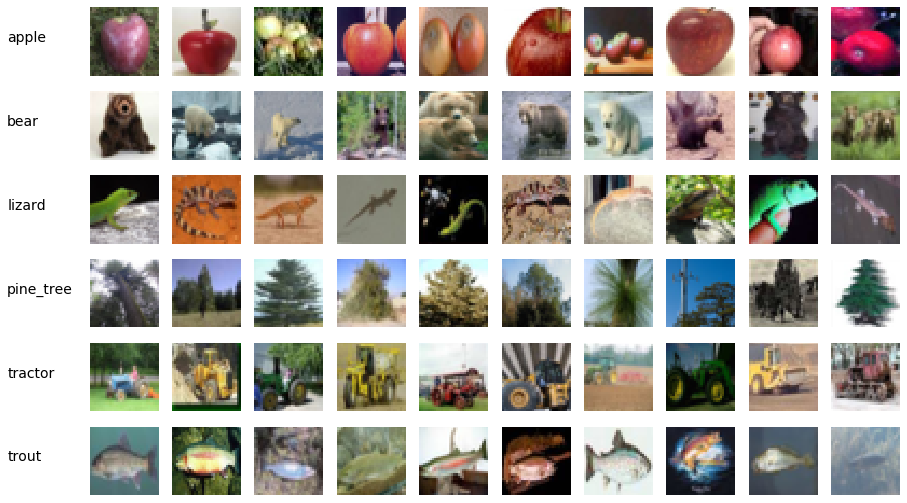

In [25]:
# plt olarak import ettiğimiz matplotlib.pyplot kütüphane ile eğitim için kullandığımız sınıfların örnek görüntüsünü alıyoruz

fig,ax = plt.subplots(6,11,figsize=(16,9))

labels = list(siniflarim.keys())

for i in range(6):
    resimler = x_train[y_train[:,0] == labels[i]]
    ax[i,0].axis("off")
    ax[i,0].text(0,0.5,siniflarim[labels[i]],fontdict={"size":14})
    for j in range(1,11):
        ax[i,j].axis("off")
        ax[i,j].imshow(resimler[j])
        
plt.show()

In [13]:
# Parametrelerin eğitilmesi :
epochs = 30                    # 30 epoch ile eğitim yapılacaktır.
batch_size = 50                # Her iterasyonda 50 fotoğraf alınır.
sinif_sayisi = len(siniflarim) # veri setinde 6  sınıf bulunmaktaonu len fonksiyon ile alıyoruz.
kanal_sayisi = x_train.shape[3]
genislik = x_train.shape[1]
uzunluk = x_train.shape[2]
 
# Modelin kaydedileceği yer belirlenir
save_dir = os.path.join(os.getcwd(), 'saved_models') 

# Kaydedilecek modelin dosya adı belirlenir
model_name = 'keras_6_classes_from_cifar100_trained_model.h5' 

In [14]:
veriseti_path = "cifar100_siniflar"

os.mkdir(veriseti_path)

train_dir = os.path.join(veriseti_path, 'train')
os.mkdir(train_dir)
test_dir = os.path.join(veriseti_path, 'test')
os.mkdir(test_dir)

save_resimler(x_train,y_train,siniflarim,train_dir)
save_resimler(x_test,y_test,siniflarim,test_dir)

FileExistsError: [WinError 183] Halen varolan bir dosya oluşturulamaz: 'cifar100_siniflar'

In [15]:
train_gen,test_gen = make_generator(train_dir,test_dir)

NameError: name 'train_dir' is not defined

In [16]:
model = make_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)        

In [29]:
#Dropout ve Veri Augmentation yapılmadan modelimizi eğitiyoruz

historyNormal = model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,
                              epochs=epochs,validation_data=test_gen,validation_steps=test_gen.samples//batch_size)

Epoch 1/75
60/60 [==============================] - 323s 5s/step - loss: 0.5797 - acc: 0.7927 - val_loss: 0.7458 - val_acc: 0.7683
Epoch 2/75
60/60 [==============================] - 286s 5s/step - loss: 0.5876 - acc: 0.7850 - val_loss: 0.5942 - val_acc: 0.7417
Epoch 3/75
60/60 [==============================] - 281s 5s/step - loss: 0.5715 - acc: 0.8000 - val_loss: 0.6246 - val_acc: 0.7683
Epoch 4/75
60/60 [==============================] - 264s 4s/step - loss: 0.5335 - acc: 0.8113 - val_loss: 0.6862 - val_acc: 0.7683
Epoch 5/75
60/60 [==============================] - 305s 5s/step - loss: 0.5208 - acc: 0.8047 - val_loss: 0.7534 - val_acc: 0.7467
Epoch 6/75
60/60 [==============================] - 373s 6s/step - loss: 0.5011 - acc: 0.8320 - val_loss: 0.4791 - val_acc: 0.7917
Epoch 7/75
60/60 [==============================] - 280s 5s/step - loss: 0.4862 - acc: 0.8270 - val_loss: 0.5291 - val_acc: 0.7767
Epoch 8/75
60/60 [==============================] - 268s 4s/step - loss: 0.4539 - a

In [20]:
model.save("kayit")

In [21]:
make_gorsel(historyNormal.history,"Dropout ve Veri Zenginleştirmeden önceki görsel")

NameError: name 'historyNormal' is not defined

<b>Dropoutlu</b>

In [22]:
model = make_model(dropout=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)        

In [37]:
# Canlı olarak arttırılan veri ile modelimizi eğitelim:

historyDroplu = model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,
                              epochs=epochs,validation_data=test_gen,validation_steps=test_gen.samples//batch_size)

Epoch 1/35
60/60 [==============================] - 248s 4s/step - loss: 1.3619 - acc: 0.4633 - val_loss: 1.3210 - val_acc: 0.5350
Epoch 2/35
60/60 [==============================] - 317s 5s/step - loss: 1.1816 - acc: 0.5393 - val_loss: 1.2973 - val_acc: 0.5650
Epoch 3/35
60/60 [==============================] - 415s 7s/step - loss: 1.0979 - acc: 0.5793 - val_loss: 1.0228 - val_acc: 0.6233
Epoch 4/35
60/60 [==============================] - 294s 5s/step - loss: 1.0677 - acc: 0.6017 - val_loss: 0.8179 - val_acc: 0.6517
Epoch 5/35
60/60 [==============================] - 296s 5s/step - loss: 0.9791 - acc: 0.6390 - val_loss: 0.7350 - val_acc: 0.6733
Epoch 6/35
60/60 [==============================] - 529s 9s/step - loss: 0.9654 - acc: 0.6457 - val_loss: 0.8174 - val_acc: 0.6717
Epoch 7/35
60/60 [==============================] - 349s 6s/step - loss: 0.9160 - acc: 0.6637 - val_loss: 1.0220 - val_acc: 0.6850
Epoch 8/35
60/60 [==============================] - 481s 8s/step - loss: 0.8730 - a

In [19]:
model.save("kayit_1")

In [1]:
make_gorsel(historyDroplu.history,"Sadece Dropout İle")

NameError: name 'make_gorsel' is not defined

<b>Veri Zenginleştirme</b>

In [49]:
model = make_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 128)        

In [57]:
train_gen,test_gen = make_generator(train_dir,test_dir,augmentation=True)

Found 3000 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [58]:
Aug_history = model.fit_generator(train_gen,steps_per_epoch=train_gen.samples//batch_size,
                              epochs=epochs,validation_data=test_gen,validation_steps=test_gen.samples//batch_size)

Epoch 1/30
60/60 [==============================] - 289s 5s/step - loss: 1.3035 - acc: 0.4807 - val_loss: 1.0609 - val_acc: 0.5500
Epoch 2/30
60/60 [==============================] - 331s 6s/step - loss: 1.1717 - acc: 0.5493 - val_loss: 1.1462 - val_acc: 0.5950
Epoch 3/30
60/60 [==============================] - 365s 6s/step - loss: 1.0874 - acc: 0.5910 - val_loss: 1.0705 - val_acc: 0.6417
Epoch 4/30
60/60 [==============================] - 279s 5s/step - loss: 1.0233 - acc: 0.6147 - val_loss: 1.0047 - val_acc: 0.6667
Epoch 5/30
60/60 [==============================] - 277s 5s/step - loss: 0.9813 - acc: 0.6353 - val_loss: 0.9298 - val_acc: 0.6800
Epoch 6/30
60/60 [==============================] - 287s 5s/step - loss: 0.9474 - acc: 0.6497 - val_loss: 1.0109 - val_acc: 0.6933
Epoch 7/30
60/60 [==============================] - 270s 4s/step - loss: 0.9232 - acc: 0.6553 - val_loss: 0.9103 - val_acc: 0.7000
Epoch 8/30
60/60 [==============================] - 325s 5s/step - loss: 0.9015 - a

In [18]:
model.save("kayit2")

In [4]:
# Eğitilmiş modelimizi kaydedelim:

# Klasör yoksa oluşturulur:
if not os.path.isdir(save_dir):
    
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Modelimizin başarısını ölçelim:

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

NameError: name 'os' is not defined

In [ ]:
# sadece veri zenginleştirme ile eğittiğimiz ağın historisini görselleştirelim

make_gorsel(historyAug.history,"Veri Zenginleştirme İle")

In [ ]:
hList = [historyNormal.history,historyDroplu.history,historyAug.history]
hAciklamalar = ["Normal","Dropout ile","Augmentation"]
make_gorsel_2(hList,hAciklamalar)

In [ ]:
hList = [historyNormal.history,historyDroplu.history]
hAciklamalar = ["Normal","Dropout ile",]
make_gorsel_2(hList,hAciklamalar)

In [ ]:
hList = [historyNormal.history,historyAug.history]
hAciklamalar = ["Normal","Augmentation"]
make_gorsel_2(hList,hAciklamalar)

In [ ]:
hList = [historyDroplu.history,historyAug.history]
hAciklamalar = ["Dropout ile","Augmentation"]
make_gorsel_2(hList,hAciklamalar)

In [ ]:
accMaxTrain = [np.max(historyNormal.history["acc"]),
          np.max(historyDroplu.history["acc"]),
          np.max(historyAug.history["acc"])]

accMaxVal = [np.max(historyNormal.history["val_acc"]),
          np.max(historyDroplu.history["val_acc"]),
          np.max(historyAug.history["val_acc"])]

x = np.arange(len(accMaxTrain))

In [ ]:
plt.figure(figsize=(12,8))

a = x-0.2
b = x+0.2
plt.bar(a,accMaxTrain,width=0.35)
plt.bar(b,accMaxVal,width=0.35)

plt.xlabel("Kullanılan Eğitimler: ")
plt.xticks(x,["Normal","Dropout ile","Augmentation ile"])
plt.ylabel("Accuracy(/100)")
plt.title("Max Accuracy Karşılaştırma")

plt.legend(["Train","Validation"])

for i in range(len(x)):
    plt.text(a[i]-0.05,accMaxTrain[i]+0.01,str("{:.3f}".format(accMaxTrain[i])))
    plt.text(b[i]-0.05,accMaxVal[i]+0.01,str("{:.3f}".format(accMaxVal[i])))
    
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

z = list()
z.append(accMaxTrain)
z.append(accMaxVal)

acc = np.array(z,dtype=np.float)
sekil = plt.figure(figsize=(12,8))
ax = Axes3D(sekil)

xlabels = np.array(['Normal','Dropout ile','Augmentation ile'])
xpos = np.arange(xlabels.shape[0])
ylabels = np.array(['Train','Validation'])
ypos = np.arange(ylabels.shape[0])
a,b = np.meshgrid(xpos,ypos,copy=False)
zpos = acc
zpos = zpos.ravel()

dx=0.5;dy=0.5;dz=zpos

ax.w_xaxis.set_ticks(xpos+0.2)
ax.w_xaxis.set_ticklabels(xlabels)
ax.w_yaxis.set_ticks(ypos+0.3)
ax.w_yaxis.set_ticklabels(ylabels)

ax.set_zlim(0,1)

ax.xaxis.set_label_text("Türler",fontweight="bold",color="black")
ax.yaxis.set_label_text("Aşama",fontweight="bold",color="red")
ax.zaxis.set_label_text("Accuracy",fontweight="bold",color="blue")

for i in xpos:
    for j in ypos:
        ax.text3D(i+0.2,j+0.2,acc[j,i],str("{:.3f}".format(acc[j,i])))
    
values = np.linspace(0.2,1.,a.ravel().shape[0])
renkler = cm.rainbow(values)
ax.bar3d(a.ravel(),b.ravel(),dz*0,dx,dy,dz,color=renkler)
plt.title( " Max Accuracy Karşılaştırma ",fontsize=20,fontname="Cambria",color="red")
plt.show()